In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
img_height, img_width = IMG_SIZE = (200, 200)
batch_size = 32

data_dir = "F:\Kuliah\Bangkit 2022\Capstone\seven_plastics\dataset"

In [3]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1078 files belonging to 3 classes.
Using 971 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1078 files belonging to 3 classes.
Using 107 files for validation.


In [5]:
# List the classes

class_names = train_ds.class_names
print(class_names)

['1_polyethylene_PET', '2_high_density_polyethylene_PE-HD', '3_others']


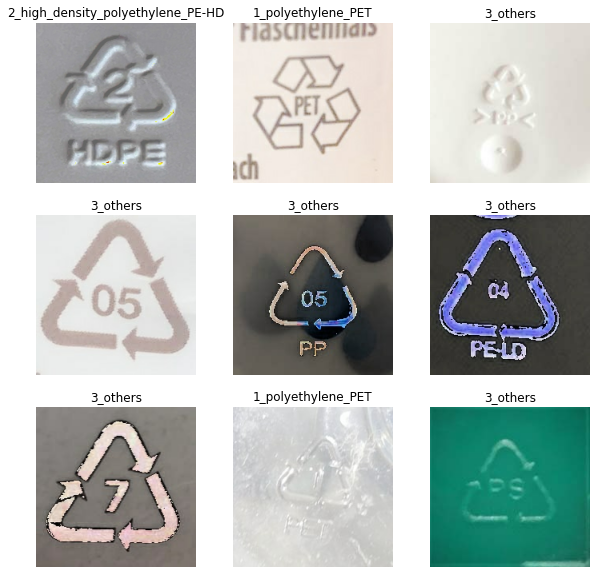

In [6]:
# Get a look at what we are training on

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [7]:
# Prefetch images to memory, to make training faster

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [12]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
base_model.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
num_classes = len(class_names)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [15]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(), # lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 200, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [18]:
initial_epochs = 300

loss0, accuracy0 = model.evaluate(val_ds)

4/4 [==============================] - 3s 246ms/step - loss: 1.4310 - accuracy: 0.3645


In [19]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/300
31/31 [==============================] - 17s 400ms/step - loss: 1.2524 - accuracy: 0.4078 - val_loss: 0.9807 - val_accuracy: 0.4766
Epoch 2/300
31/31 [==============================] - 12s 391ms/step - loss: 0.9816 - accuracy: 0.5623 - val_loss: 0.8619 - val_accuracy: 0.5234
Epoch 3/300
31/31 [==============================] - 12s 390ms/step - loss: 0.9035 - accuracy: 0.5870 - val_loss: 0.8506 - val_accuracy: 0.5888
Epoch 4/300
31/31 [==============================] - 13s 402ms/step - loss: 0.8392 - accuracy: 0.6159 - val_loss: 0.7884 - val_accuracy: 0.6262
Epoch 5/300
31/31 [==============================] - 13s 396ms/step - loss: 0.7509 - accuracy: 0.6653 - val_loss: 0.7731 - val_accuracy: 0.6168
Epoch 6/300
31/31 [==============================] - 12s 394ms/step - loss: 0.7313 - accuracy: 0.6694 - val_loss: 0.7557 - val_accuracy: 0.7009
Epoch 7/300
31/31 [==============================] - 12s 398ms/step - loss: 0.6829 - accuracy: 0.7075 - val_loss: 0.7512 - val_accuracy:

31/31 [==============================] - 13s 420ms/step - loss: 0.4300 - accuracy: 0.8260 - val_loss: 0.7160 - val_accuracy: 0.7383
Epoch 107/300
31/31 [==============================] - 13s 413ms/step - loss: 0.4125 - accuracy: 0.8404 - val_loss: 0.7595 - val_accuracy: 0.7477
Epoch 108/300
31/31 [==============================] - 13s 412ms/step - loss: 0.4470 - accuracy: 0.8260 - val_loss: 0.7790 - val_accuracy: 0.7664
Epoch 109/300
31/31 [==============================] - 13s 415ms/step - loss: 0.4039 - accuracy: 0.8260 - val_loss: 0.7616 - val_accuracy: 0.7570
Epoch 110/300
31/31 [==============================] - 13s 416ms/step - loss: 0.4345 - accuracy: 0.8321 - val_loss: 0.8306 - val_accuracy: 0.7664
Epoch 111/300
31/31 [==============================] - 13s 415ms/step - loss: 0.4544 - accuracy: 0.8229 - val_loss: 0.8198 - val_accuracy: 0.7290
Epoch 112/300
31/31 [==============================] - 13s 415ms/step - loss: 0.4037 - accuracy: 0.8455 - val_loss: 0.7794 - val_accuracy:

31/31 [==============================] - 13s 419ms/step - loss: 0.3785 - accuracy: 0.8404 - val_loss: 0.7725 - val_accuracy: 0.7664
Epoch 219/300
31/31 [==============================] - 13s 419ms/step - loss: 0.4515 - accuracy: 0.8146 - val_loss: 0.7610 - val_accuracy: 0.7570
Epoch 220/300
31/31 [==============================] - 13s 424ms/step - loss: 0.4066 - accuracy: 0.8486 - val_loss: 0.7633 - val_accuracy: 0.7383
Epoch 221/300
31/31 [==============================] - 13s 423ms/step - loss: 0.4203 - accuracy: 0.8280 - val_loss: 0.8083 - val_accuracy: 0.7664
Epoch 222/300
31/31 [==============================] - 13s 422ms/step - loss: 0.3843 - accuracy: 0.8342 - val_loss: 0.8256 - val_accuracy: 0.7290
Epoch 223/300
31/31 [==============================] - 13s 418ms/step - loss: 0.4042 - accuracy: 0.8414 - val_loss: 0.8041 - val_accuracy: 0.7570
Epoch 224/300
31/31 [==============================] - 13s 420ms/step - loss: 0.4126 - accuracy: 0.8435 - val_loss: 0.7824 - val_accuracy:

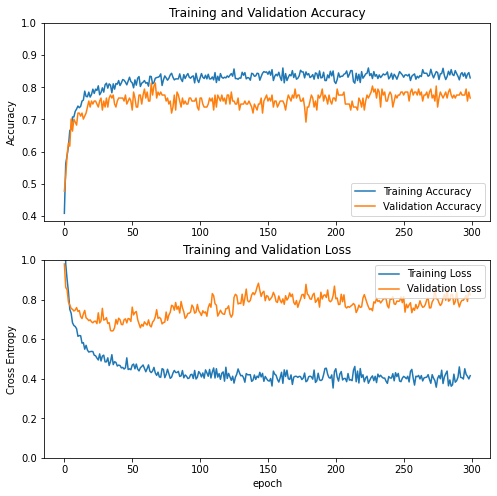

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
export_path = "F:\Kuliah\Bangkit 2022\Capstone\saved_model3"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: F:\Kuliah\Bangkit 2022\Capstone\saved_model3\assets


INFO:tensorflow:Assets written to: F:\Kuliah\Bangkit 2022\Capstone\saved_model3\assets


'F:\\Kuliah\\Bangkit 2022\\Capstone\\saved_model3'

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

CLASS_NAMES = ['PET', 'HDPE', 'Others']

new_model = tf.keras.models.load_model('saved_model2')

test_path = "F:/Kuliah/Bangkit 2022/Capstone/test"

for image in os.listdir(test_path):
    if(image == '.ipynb_checkpoints'):
        continue
    img = cv2.imread(test_path+"/"+image)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     # as opencv loads in BGR format by default, we want to show it in RGB.
    plt.show()
    
    img = cv2.resize(img,(200,200))
    img = np.expand_dims(img,0)
    predict = new_model.predict(img)
#   print(image)
    print(predict)
    result = CLASS_NAMES[predict.argmax(axis=1)[0]]
    print(result)

In [2]:
import tensorflow as tf

saved_model_dir = "saved_model2"

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)